In [1]:
import numpy as np
import shtns
import pylab as py
import matplotlib
from tqdm import tqdm
import sys
import time as ti

sys.path.append('/data/pbarpanda/python_scripts/modules/')
import logruns as logruns
import save_and_load_hdf5_files as h5saveload
import eulerian_fluxes as eflux
import netcdf_utilities as ncutil
from obspy.geodetics import kilometers2degrees
import momentum_advection_class as momentum_advect

import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'  ### This is because NOAA PSL lab computers are somehow not able to use 


class Spharmt(object):
    """
    wrapper class for commonly used spectral transform operations in
    atmospheric models.  Provides an interface to shtns compatible
    with pyspharm (pyspharm.googlecode.com).
    """
    def __init__(self, nlons, nlats, ntrunc, rsphere, gridtype="gaussian"):
        """initialize
        nlons:  number of longitudes
        nlats:  number of latitudes"""
        self._shtns = shtns.sht(ntrunc, ntrunc, 1,
                                shtns.sht_orthonormal+shtns.SHT_NO_CS_PHASE)

        if gridtype == "gaussian":
            # self._shtns.set_grid(nlats, nlons,
            #         shtns.sht_gauss_fly | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_quick_init | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
        elif gridtype == "regular":
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_reg_dct | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)

        self.lats = np.arcsin(self._shtns.cos_theta)
        self.lons = (2.*np.pi/nlons)*np.arange(nlons)
        self.nlons = nlons
        self.nlats = nlats
        self.ntrunc = ntrunc
        self.nlm = self._shtns.nlm
        self.degree = self._shtns.l
        self.m      = self._shtns.m
        self.lap    = -self.degree*(self.degree+1.0).astype(np.complex128)
        self.invlap = np.zeros(self.lap.shape, self.lap.dtype)
        self.invlap[1:] = 1./self.lap[1:]
        self.rsphere = rsphere
        self.lap     = self.lap/rsphere**2
        self.invlap  = self.invlap*rsphere**2

    def grdtospec(self, data):
        """compute spectral coefficients from gridded data"""
        return self._shtns.analys(data)

    def spectogrd(self, dataspec):
        """compute gridded data from spectral coefficients"""
        return self._shtns.synth(dataspec)

    def getuv(self, vrtspec, divspec):
        """compute wind vector from spectral coeffs of vorticity and divergence"""
        return self._shtns.synth((self.invlap/self.rsphere)*vrtspec, (self.invlap/self.rsphere)*divspec)

    def getvrtdivspec(self, u, v):
        """compute spectral coeffs of vorticity and divergence from wind vector"""
        vrtspec, divspec = self._shtns.analys(u, v)
        return self.lap*self.rsphere*vrtspec, self.lap*rsphere*divspec

    def getgrad(self, divspec):
        """compute gradient vector from spectral coeffs"""
        vrtspec = np.zeros(divspec.shape, dtype=np.complex128)
        u, v = self._shtns.synth(vrtspec, divspec)
        return u/rsphere, v/rsphere
    
      
import matplotlib.pyplot as plt
import time
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "darkred", "darkorange", "pink", "white", "white","skyblue", "dodgerblue", "navy"][::-1])

def phi_T(y, y0=0, H0=100,  N=2):
    ## y takes latitude in radians
    y0=np.deg2rad(y0)
    phi = grav*H0*(1-(np.sin(y)-np.sin(y0))**N)
    return phi

def phi_B(Hmean):
    phi = grav*Hmean
    return phi


def PHI_perturb(lons, lats, Q0=100, yp=0, xp=90, Lx=30, Ly=10, time = 0, switch_on_day=None):
    
    if switch_on_day:
        switch_on_time = switch_on_day*24*3600
        if time >= switch_on_time:
            flag = 1
        else:
            flag = 0
    else:
        flag = 1
        
    xp, yp, Lx, Ly      = map(lambda z: np.deg2rad(z), [xp, yp, Lx, Ly ])
    phi_perturb         = flag * grav * Q0*np.exp(-   (((lats-yp)**2/Ly**2) +  ((lons-xp)**2/Lx**2))   )
    phi_mean            = np.mean(phi_perturb, axis=-1, keepdims=True)    
    phi_peturb_anom     = phi_perturb - phi_mean
    return phi_perturb, phi_peturb_anom


def PHI_perturb_propagating(lons, lats, Q0=100, yp=0, xp=90, Lx=30, Ly=10, time = 0, switch_on_day=None, c=5, wave_number=2):
    
    def heating_dipole(shift, wave_number=2,):
        
        shift = shift%(2*np.pi)
        K     = wave_number
        dipole        = np.sin(K*(lons - shift))
        if (shift+2*np.pi/K) > (2*np.pi):
            end_point = shift
            beg_point = shift + (2*np.pi/K) - 2*np.pi
            zero_lon  = ((lons<end_point)) & (lons>beg_point)
        else:
            beg_point = shift
            end_point = shift + 2*np.pi/K
            zero_lon  = ((lons<beg_point)) | (lons>end_point)
            
        dipole[zero_lon] = 0
        
        return dipole
        
    if switch_on_day:
        switch_on_time = switch_on_day*24*3600
        if time >= switch_on_time:
            flag = 1
        else:
            flag = 0
    else:
        flag = 1
        
    shift  = kilometers2degrees((c*(time-switch_on_time))/1000)
    
    xp, yp, Lx, Ly, shift      = map(lambda z: np.deg2rad(z), [xp, yp, Lx, Ly, shift ])
    dipole = heating_dipole(shift, wave_number=wave_number)
        
    phi_perturb         = flag * grav * Q0*np.exp(  -(((lats-yp)**2/Ly**2)) ) * dipole
    phi_mean            = np.mean(phi_perturb, axis=-1, keepdims=True)    
    phi_peturb_anom     = phi_perturb - phi_mean
    return phi_perturb, phi_peturb_anom


def PHI_perturb_from_file(external_data, time = 0, switch_on_day=None,):
    if switch_on_day:
        switch_on_time  = switch_on_day*24*3600
        if time        >= switch_on_time:
            flag        = 1
        else:
            flag        = 0
    else:
        flag            = 1
            
    time_in_hours       = int(time//3600)
    time_in_hours       = time_in_hours%(48*24)    
    phi_perturb         = flag*external_data[time_in_hours]
    return phi_perturb[time], 
    
    
def F_uv_perturb(lons, lats, Fo=100, yp=0, xp=90, Lx=30, Ly=10, time = 0, switch_on_day=None):
    
    if switch_on_day:
        switch_on_time = switch_on_day*24*3600
        if time >= switch_on_time:
            flag = 1
        else:
            flag = 0
    else:
        flag = 1
        
    xp, yp, Lx, Ly  = map(lambda z: np.deg2rad(z), [xp, yp, Lx, Ly ])
    perturb         = flag * Fo * np.exp(-   (((lats-yp)**2/Ly**2) +  ((lons-xp)**2/Lx**2))   )
    perturb_mean    = np.nanmean(perturb, axis=-1, keepdims=True)    
    peturb_anom     = perturb - perturb_mean
    return perturb, peturb_anom

def A(Z):
    return np.array(Z)

def initial_conditions(sp_harmonic):
        
    vg   =               np.zeros((nlats, nlons), np.float64)
    ug   =               np.zeros((nlats, nlons), np.float64)
    phig =               np.zeros((nlats, nlons), np.float64)

    # initial vorticity, divergence in spectral space
    vrtspec, divspec = sp_harmonic.getvrtdivspec(ug, vg)
    vrtg = sp_harmonic.spectogrd(vrtspec)
    divg = sp_harmonic.spectogrd(divspec)

    # Nonlinear terms on the RHS
    u_f_plus_vort = ug*(vrtg+f)
    v_f_plus_vort = vg*(vrtg+f)

    curl_NL_spec, div_NL_spec = sp_harmonic.getvrtdivspec(u_f_plus_vort, v_f_plus_vort)
    KE_spec = sp_harmonic.grdtospec(0.5*(ug**2+vg**2))
    phispec = sp_harmonic.grdtospec(phig)


    ### Try this part later. Where you start from a balanced condition with a perturbation
    # balanced_phispec = sp_harmonic.invlap*curl_NL_spec - KE_spec
    # phig    = phi_B(Hmean)+ \
    #           perturb(lons, lats, Q0=100, yp=0, xp=90, Lx=30, Ly=10)[1] + \
    #           sp_harmonic.spectogrd(balanced_phispec)
    # phispec = x.grdtospec(phig)
    
    return ug, vg, phig, vrtg, divg, vrtspec, divspec, KE_spec, phispec



def integrate_model(input_file2):
    
    abort_status = 'False'
    
    U   = []; 
    V   = [];
    PHI = [];
    VRT = [];
    DIV = [];    
    PHI_forcing   = []
    F_vrt_forcing = []
    F_div_forcing = []
    
    U_spec   = []; 
    V_spec   = [];
    PHI_spec = [];
    VRT_spec = [];
    DIV_spec = [];
    PHI_forcing_spec   = []
    F_vrt_forcing_spec = []
    F_div_forcing_spec = []
    
    T = [];
        
    for key in input_file.keys():
        globals()[key] = input_file2[key] 
    
    # setup up spherical harmonic instance, set lats/lons of grid
    sp_harmonic = Spharmt(nlons, nlats, ntrunc, rsphere, gridtype="gaussian")
    lons, lats  = np.meshgrid(sp_harmonic.lons, sp_harmonic.lats)
    global f
    f           = 2.*omega*np.sin(lats)   # coriolis
    
        
    ug, vg, phig, vrtg, divg, vrtspec, divspec, KE_spec, phispec = initial_conditions(sp_harmonic)

    ddivdtspec = np.zeros(vrtspec.shape+(3,), np.complex128)
    dvrtdtspec = np.zeros(vrtspec.shape+(3,), np.complex128)
    dphidtspec = np.zeros(vrtspec.shape+(3,), np.complex128)
    nnew = 0
    nnow = 1
    nold = 2
    
    H0_values = np.ones(itmax)*Hmax
    tmax_25   = spin_up_time*int(86400/dt)
    H0_spinup = np.linspace(0, Hmax, tmax_25)
    H0_values[:tmax_25] = H0_spinup
    
    for ncycle in tqdm(range(itmax)):
        
        t = ncycle*dt
        
        if int(t/(24*3600)) > 5 :
            
            if t % (3*3600) == 0: ### Save every 3 hours
                U.append(ug)
                V.append(vg)
                PHI.append(phig)
                VRT.append(vrtg)
                DIV.append(divg)
                
                U_spec.append(sp_harmonic.grdtospec(ug))
                V_spec.append(sp_harmonic.grdtospec(vg))
                PHI_spec.append(phispec)
                VRT_spec.append(vrtspec)
                DIV_spec.append(divspec)
                
                T.append(t/(24*3600)) 
        
        # get vort, u, v, phi on grid
        vrtg   = sp_harmonic.spectogrd(vrtspec)
        ug, vg = sp_harmonic.getuv(vrtspec, divspec)
        phig   = sp_harmonic.spectogrd(phispec)
        H0     = H0_values[ncycle]
        phig_plus_phiT = phig + phi_T(lats, y0, H0,  N, )

        # compute tendencies.
        u_f_plus_vort = ug*(vrtg+f)
        v_f_plus_vort = vg*(vrtg+f)
        curl_NL_spec, div_NL_spec =   sp_harmonic.getvrtdivspec(u_f_plus_vort, v_f_plus_vort)
        ddivdtspec[:, nnew]       =   curl_NL_spec
        dvrtdtspec[:, nnew]       = - div_NL_spec

        u_phi = ug*phig
        v_phi = vg*phig
        curl_uvphi_NL_spec, div_uvphi_NL_spec = sp_harmonic.getvrtdivspec(u_phi, v_phi)

        dphidtspec[:, nnew]   = -div_uvphi_NL_spec
        KE_plus_phi_spec      =  sp_harmonic.grdtospec(phig_plus_phiT+0.5*(ug**2+vg**2))
        ddivdtspec[:, nnew]  += -sp_harmonic.lap*KE_plus_phi_spec

        #### Diffusion term ####
        vrtg_diffuse_spec, div_diffuse_spec   =  sp_harmonic.getvrtdivspec(ug, vg)
        phi_diffuse_spec                      =  sp_harmonic.grdtospec(phig - phi_B(Hmean))
        dvrtdtspec[:, nnew]   += -vrtg_diffuse_spec/K_M
        ddivdtspec[:, nnew]   += -div_diffuse_spec/K_M
        dphidtspec[:, nnew]   += -phi_diffuse_spec/K_T


        ##### EXTERNAL FORCING ######
        time_component        = 0 #np.sin(2*np.pi*t/(time_period*24*3600))

        phi_forcing           = PHI_perturb_propagating(lons, lats, Q0, yp, xp, Lx, Ly, t, switch_on_day, c=forcing_phase_speed, wave_number=forcing_wave_number)[0]

#       phi_forcing           = (PHI_perturb_from_file(external_data, time = 0, switch_on_day=None)[0])
        fu_forcing            = (F_uv_perturb(lons, lats, FUo, yp, xp, Lx, Ly, t, switch_on_day)[0])*time_component 
        fv_forcing            = (F_uv_perturb(lons, lats, FVo, yp, xp, Lx, Ly, t, switch_on_day)[0])*time_component 
        
        f_vrt_forcing_spec, f_div_forcing_spec    =   sp_harmonic.getvrtdivspec(fu_forcing, fv_forcing)
        f_vrt_forcing    =   sp_harmonic.spectogrd(f_vrt_forcing_spec)
        f_div_forcing    =   sp_harmonic.spectogrd(f_div_forcing_spec)

        phi_forcing_spec      = sp_harmonic.grdtospec(phi_forcing)/K_T
        dphidtspec[:, nnew]   += phi_forcing_spec
        dvrtdtspec[:, nnew]   += f_vrt_forcing_spec
        ddivdtspec[:, nnew]   += f_div_forcing_spec        
        
        if int(t/(24*3600)) > 5 :           
            if t % (3*3600) == 0: ### Save every 6 hours
                
                PHI_forcing       .append(phi_forcing)
                PHI_forcing_spec  .append(phi_forcing_spec)
                
                F_vrt_forcing     .append(f_vrt_forcing)
                F_vrt_forcing_spec.append(f_vrt_forcing_spec)
                
                F_div_forcing     .append(f_div_forcing)
                F_div_forcing_spec.append(f_div_forcing_spec)


        # update vort, div, phiv with third-order adams-bashforth.
        # forward euler, then 2nd-order adams-bashforth time steps to start.
        if ncycle == 0:
            dvrtdtspec[:, nnow] = dvrtdtspec[:, nnew]
            dvrtdtspec[:, nold] = dvrtdtspec[:, nnew]
            ddivdtspec[:, nnow] = ddivdtspec[:, nnew]
            ddivdtspec[:, nold] = ddivdtspec[:, nnew]
            dphidtspec[:, nnow] = dphidtspec[:, nnew]
            dphidtspec[:, nold] = dphidtspec[:, nnew]
        elif ncycle == 1:
            dvrtdtspec[:, nold] = dvrtdtspec[:, nnew]
            ddivdtspec[:, nold] = ddivdtspec[:, nnew]
            dphidtspec[:, nold] = dphidtspec[:, nnew]

        vrtspec += dt*(
            (23./12.)*dvrtdtspec[:, nnew] - (16./12.)*dvrtdtspec[:, nnow]
            + (5./12.)*dvrtdtspec[:, nold])
        divspec += dt*(
            (23./12.)*ddivdtspec[:, nnew] - (16./12.)*ddivdtspec[:, nnow]
            + (5./12.)*ddivdtspec[:, nold])
        phispec += dt*(
            (23./12.)*dphidtspec[:, nnew] - (16./12.)*dphidtspec[:, nnow]
            + (5./12.)*dphidtspec[:, nold])
        # implicit hyperdiffusion for vort and div.
        # vrtspec *= hyperdiff_fact
        # divspec *= hyperdiff_fact

        # switch indices, do next time step.
        nsav1 = nnew
        nsav2 = nnow
        nnew = nold
        nnow = nsav1
        nold = nsav2
        
        if t/(24*3600) % 1 == 0 :
            logging_object.write("Calculated day %d"%(t/(24*3600)))
            
            
        if np.isnan(ug).any():  #### this is to make sure that the model which doesn't run stably is aborted immediately
            logging_object.write("ABORTING for Q0 = %d because of a runaway scenario at %d"%(Q0, t/(24*3600)))
            print ("ABORTING for Q0 = %d because of a runaway scenario at %d"%(Q0, t/(24*3600)))
            abort_status='True'
            break

    
    spatial_data  =  {'U': A(U),      'V': A(V),      'PHI': A(PHI),     'VRT': A(VRT),      'DIV': A(DIV),      \
                      'lats': sp_harmonic.lats, 'lons': sp_harmonic.lons, 'T_in_days':A(T),  \
                      'phi_T': phi_T(lats, y0, H0,  N), 'phi_B': phi_B(Hmean), 'phi_forcing': A(PHI_forcing), \
                      'vrt_forcing': A(F_vrt_forcing), 'div_forcing': A(F_div_forcing), 'abort_status':abort_status }
    
    spectral_data =  {'U': A(U_spec), 'V': A(V_spec), 'PHI': A(PHI_spec),'VRT': A(VRT_spec), 'DIV': A(DIV_spec), \
                      'l': sp_harmonic.degree, 'm': sp_harmonic.m, 'T_in_days': A(T), \
                      'phi_T': phi_T(lats, y0, H0,  N), 'phi_B': phi_B(Hmean), 'phi_forcing':A(PHI_forcing_spec), \
                      'vrt_forcing': A(F_vrt_forcing_spec), 'div_forcing': A(F_div_forcing_spec), 'abort_status':abort_status }
    
    path2 = path +'/H0_%s/'%(Hmax)
    h5saveload.make_sure_path_exists(path2)  
    h5saveload.save_dict_to_hdf5(spatial_data,  path2+'spatial_data.hdf5')
    h5saveload.save_dict_to_hdf5(spectral_data, path2+'spectral_data.hdf5')
    h5saveload.save_dict_to_hdf5(input_file2,   path2+'input_file.hdf5')
    
    logging_object.write("Saved data in %s"%(path2))
    
    

In [19]:
if __name__ == "__main__": 
    
    for H0 in [0]:  
        
        for forcing_y_loc in [0]:
            
            for Q0 in [1500]:
                
                for forcing_phase_speed in [5]:
                    
                    for forcing_wave_number in [1,]:
                        
                        start_time=ti.time() 

                        print (Q0)
                        switch_on_day  = 45
                        FUo            =  0 #0.0001 #float(sys.argv[4])  
                        logging_object = logruns.default_log(logfilename   = 'propagating_force', \
                                                             log_directory = '~/Work/spherical_SWE/shell_scripts/log/')

                        input_file = {  'nlons'        : 256        , \
                                        'ntrunc'       : int(256/3) , \
                                        'nlats'        : int(256/2) , \
                                        'dt'           : 150        , \
                                        'itmax'        : 1*40*int(86400/150) , \
                                        'spin_up_time' : 25         , \
                                        'rsphere'      : 6.37122e6  , \
                                        'omega'        : 7.292e-5   , \
                                        'grav'         : 9.80616    , \
                                        'umax'         : 30.        , \
                                        'hamp '        : 120.       , \
                                        'efold'        : 3.*3600.   , \
                                        'ndiss'        : 8          , \
                                        'y0'           : 0,  'N':2, 'Hmax': 2000, \
                                        'Hmean'        : 800 , \
                                        'Q0'           : Q0 , 'yp'  : 0 , 'xp': 90 , 'Lx': 30 , 'Ly': 10, \
                                        'FUo'          : 0 ,  'FVo' : 0 ,  \
                                        'K_M'          : 20*24*3600, 'K_T': 10*24*3600, \
                                        'switch_on_day': 25, \
                                        'forcing_phase_speed': forcing_phase_speed, \
                                        'forcing_wave_number': forcing_wave_number , \
                                        'path'         : '/data/pbarpanda/spherical_SWE/Hoskins_type_forcing/propagating_Q_forcing/' } ; 

                        input_file['ntrunc']        = int(input_file['nlons']/3)
                        input_file['nlats']         = int(input_file['nlons']/2)
                        input_file['itmax']         = 200*int(86400/int(input_file['dt']))   #### Here 150 is in the units of days
                        input_file['Hmax']          = H0
                        input_file['switch_on_day'] = switch_on_day
                        input_file['yp']            = forcing_y_loc
                        input_file['path']          = \
                        input_file['path']+'/Q_forcing_%d/forcing_y_%d/forcing_phase_speed_%d_ms/'%(input_file['Q0'], input_file['yp'], input_file['forcing_phase_speed'])

                        path2 = input_file['path'] +'/H0_%s/'%(input_file['Hmax'])

#                         if not os.path.exists(path2):
#                             print (' %s integrating'%(path2))
#                             integrate_model(input_file)
#                         else:
#                             logging_object.write( ' %s exists'%(path2) )
#                             print (' %s exists'%(path2))

#                         end_time=ti.time() 

#                         logging_object.write(' ========== CODE RAN SUCCESSFULLY, congrats! ================')
#                         logging_object.write(' -----> Total Time taken = %1.3f  <----'%(end_time-start_time))
    


1500


In [4]:
for key in input_file.keys():
    globals()[key] = input_file[key] 

In [5]:
sp_harmonic = Spharmt(nlons, nlats, ntrunc, rsphere, gridtype="gaussian")
lons, lats  = np.meshgrid(sp_harmonic.lons, sp_harmonic.lats)


In [20]:
def PHI_perturb_propagating(lons, lats, Q0=100, yp=0, xp=90, Lx=30, Ly=10, time = 0, switch_on_day=None, c=5, wave_number=2):
    
    def heating_dipole(shift, wave_number=2,):
        
        shift = shift%(2*np.pi)
        K     = wave_number
        dipole        = np.sin(K*(lons - shift))
        if (shift+2*np.pi/K) > (2*np.pi):
            end_point = shift
            beg_point = shift + (2*np.pi/K) - 2*np.pi
            zero_lon  = ((lons<end_point)) & (lons>beg_point)
        else:
            beg_point = shift
            end_point = shift + 2*np.pi/K
            zero_lon  = ((lons<beg_point)) | (lons>end_point)
            
        dipole[zero_lon] = 0
        
        return dipole
    
    
    def heating_monopole(shift, wave_number=2,):
        
        shift = shift%(2*np.pi)
        K     = wave_number
        dipole        = np.sin(K*(lons - shift))
        if (shift+1*np.pi/K) > (2*np.pi):
            end_point = shift
            beg_point = shift + (1*np.pi/K) - 2*np.pi
            zero_lon  = ((lons<end_point)) & (lons>beg_point)
        else:
            beg_point = shift
            end_point = shift + 1*np.pi/K
            zero_lon  = ((lons<beg_point)) | (lons>end_point)
            
        dipole[zero_lon] = 0
        
        return dipole

    
    if switch_on_day:
        switch_on_time = switch_on_day*24*3600
        if time >= switch_on_time:
            flag = 1
        else:
            flag = 0
    else:
        flag = 1
        
    shift  = kilometers2degrees((c*(time-switch_on_time))/1000)
    
    xp, yp, Lx, Ly, shift      = map(lambda z: np.deg2rad(z), [xp, yp, Lx, Ly, shift ])
    dipole   = heating_dipole  (shift, wave_number=wave_number)
    monopole = heating_monopole(shift, wave_number=wave_number)
        
    phi_perturb         = flag * grav * Q0*np.exp(  -(((lats-yp)**2/Ly**2)) ) * np.exp(  -(((lons-xp)**2/Lx**2)) )
    phi_mean            = np.mean(phi_perturb, axis=-1, keepdims=True)    
    phi_peturb_anom     = phi_perturb - phi_mean
    return phi_perturb, phi_peturb_anom


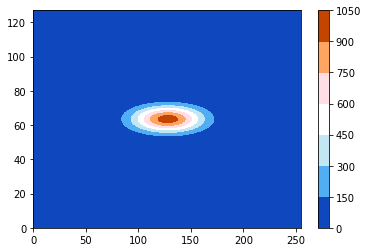

In [28]:
n=10
q1, q1p = PHI_perturb_propagating(lons, lats, Q0=100, yp=0, xp=180, Lx=45, Ly=10, time = n*24*3600, switch_on_day=1, c=0, wave_number=0.5)
py.contourf(q1, cmap=cmap); py.colorbar()

In [ ]:
ls